In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import copy
from skimage import io as skio
from skimage.transform import rescale
import sys
import dp_numpy
from pathlib import Path

In [14]:
for name in ['barbara','peppers_bw']:
    f = np.load('images/'+name+'_noisy.npy')
    M,N = f.shape[0:2]
    white = np.ones([M,N])
    plt.imsave('results/images_paper/'+name+'_white.png',white,vmin=0,vmax=1,cmap='gray')


In [15]:
for name in ['barbara','peppers_bw']:
    f = np.load('images/'+name+'.npy')
    plt.imsave('results/images_paper/'+name+'.png',f,vmin=0,vmax=1,cmap='gray')

# Compute Belief Propagation Ground Truths

In [56]:
reg_par_list = [10,15,20,30,50]
reg_par_list = [30]
tau_list = [1e-5,1e-6]

for name in ['barbara','peppers_bw']:
    for reg_num,reg_par in enumerate(reg_par_list):
    
        ##################################
        ##################################
        # Belief Propagation
        f = np.load('images/'+name+'_noisy.npy')
        M,N = f.shape[0:2]
        
        # save white image as a spacer for figures in paper
        white = np.ones([M,N])
        plt.imsave('results/images_paper/'+name+'_white.png',white,vmin=0,vmax=1,cmap='gray')

        sigma = 0.05
        K = 100
        labels=np.linspace(0,1,K)
        unaries = (f[:,:,np.newaxis] - labels[np.newaxis,np.newaxis,:])**2/(2*sigma**2)

        ##################################
        # Pairwise
        k,l = np.meshgrid(labels, labels)

        # Truncated TV
        T = 1
        lamb = reg_par
        pairwise = np.clip(np.abs(k-l), a_min = None, a_max = T) *lamb
        w = None
        NB = None


        # Sweep BP: Horizontal+Vertical
        one_hot,map_labels,marginals = dp_numpy.sbp(unaries, pairwise, w, NB, maxit=10, softmin=True, verbose=1)

        # compute normalized marginal distributions
        mm = -marginals.copy()
        mm -= mm.max(axis=-1, keepdims=True)
        mm = np.exp(mm)
        mm /= np.sum(mm, axis=-1, keepdims=True)

        # compute MMSE
        u_bp = np.sum(mm*labels[np.newaxis,np.newaxis,:], axis=-1)

        # compute pixel variance
        var_bp = np.sum(mm*(labels[np.newaxis,np.newaxis,:]-u_bp[:,:,None])**2, axis=-1)
        
        folder = Path(f'results/imaging_examples/denoising')
        folder.mkdir(parents=True, exist_ok=True)
        
        np.save(folder / f'{name}_reg_par_{reg_par}_data_par_399,99999999999994_belief_propagation_mmse.npy',u_bp)
        np.save(folder / f'{name}_reg_par_{reg_par}_data_par_399,99999999999994_belief_propagation_variance.npy',var_bp)

        
            

Pairwise cost: FULL
iter =  0 , time =  5.93047 , E =  39689.43136
iter =  1 , time =  11.73460 , E =  38195.81905
iter =  2 , time =  17.53017 , E =  38052.94727
iter =  3 , time =  23.36772 , E =  38006.41976
iter =  4 , time =  29.22823 , E =  37998.16547
iter =  5 , time =  35.08622 , E =  37987.60160
iter =  6 , time =  40.98762 , E =  37987.67565
iter =  7 , time =  46.83775 , E =  37987.22203
iter =  8 , time =  52.80297 , E =  37987.30250
iter =  9 , time =  58.61942 , E =  37987.38232
Pairwise cost: FULL
iter =  0 , time =  8.50303 , E =  37523.08003
iter =  1 , time =  16.97114 , E =  35585.89200
iter =  2 , time =  25.47073 , E =  35414.12811
iter =  3 , time =  33.93184 , E =  35325.04878
iter =  4 , time =  42.39173 , E =  35305.72877
iter =  5 , time =  50.89607 , E =  35303.21143
iter =  6 , time =  59.41686 , E =  35295.89944
iter =  7 , time =  67.96604 , E =  35293.20085
iter =  8 , time =  76.47168 , E =  35291.41830
iter =  9 , time =  84.96362 , E =  35289.83787


# Graphs Comparing BP with Proposed for Denoising for all Step Sizes and Reg Parameters

In [7]:
reg_par_list = [30]
error_dict = {}
var_err_dict = {}
niter = int(5e5-500)
burnin = int(5e5)
step = 500
tau_list = [1e-5,1e-6]

ld = 1e-4

images_folder = Path('results/images_paper/image_denoising/')
images_folder.mkdir(parents=True, exist_ok=True)
results_folder = Path('results/imaging_examples/denoising/')
results_folder_BP = Path('results/imaging_examples/denoising')

for method in ['subgrad','myula']:
    (images_folder / method).mkdir(parents=True, exist_ok=True)
    error_dict_method = {}
    var_err_dict_method = {}
    for name in ['barbara','peppers_bw']:
        err = np.zeros([len(reg_par_list),len(tau_list),round(niter//step)+1])
        var_err = np.zeros([len(reg_par_list),len(tau_list),round(niter//step)+1])
        for reg_num,reg_par in enumerate(reg_par_list):

            results_folder_Langevin = results_folder / method / name / 'data_par_399.99999999999994reg_par_30'
            
            u_bp = np.load(results_folder_BP / f'{name}_reg_par_{reg_par}_data_par_399,99999999999994_belief_propagation_mmse.npy')
            var_bp = np.load(results_folder_BP / f'{name}_reg_par_{reg_par}_data_par_399,99999999999994_belief_propagation_variance.npy')

            plt.imsave(images_folder / f'{name}_reg_par_{reg_par}_data_par_399,99999999999994_belief_propagation_mmse.png',
                        u_bp,vmin=0,vmax=1,cmap='gray')
            plt.imsave(images_folder / f'{name}_reg_par_{reg_par}_data_par_399,99999999999994_belief_propagation_variance.png',
                        var_bp,cmap='hot',vmin=0.0004,vmax = 0.0026)

            for tau_num,tau in enumerate(tau_list):

                if method=='myula':
                    params_name = f'ld_{ld}_tau_{tau}'
                elif method=='subgrad':
                    params_name = f'tau_{tau}'

                u_langevin = np.load(results_folder_Langevin / f'{params_name}_iter_{int(niter+burnin)}_mmse.npy').squeeze()
                var_langevin = np.load(results_folder_Langevin / f'{params_name}_iter_{int(niter+burnin)}_variance.npy').squeeze()
                x0 = np.load(results_folder_Langevin / f'{params_name}_x0.npy').squeeze()
                
                plt.imsave(images_folder / method / f'{name}_x0.png',
                          x0.squeeze(),vmin=0,vmax=1,cmap='gray')

                plt.imsave(images_folder / method / f'{name}_reg_par_{reg_par}_data_par_399,99999999999994_{params_name}_iter_{int(niter+burnin)}_mmse.png',
                          u_langevin.squeeze(),vmin=0,vmax=1,cmap='gray')
                
                
                f = plt.figure(frameon=False)
                f = plt.imshow(var_langevin.squeeze(),cmap='hot',extent = (0,1,0,1),vmin=0.0004,vmax = 0.0026)
                plt.colorbar(f)
                plt.tick_params(which = 'both', size = 0, labelsize = 0)
                plt.savefig(images_folder / method / f'{name}_reg_par_{reg_par}_data_par_399,99999999999994_{params_name}_iter_{int(niter+burnin)}_variance_colorbar.png')
                plt.close('all')
                plt.imsave(images_folder / method / f'{name}_reg_par_{reg_par}_data_par_399,99999999999994_{params_name}_iter_{int(niter+burnin)}_variance.png',
                          var_langevin.squeeze(),cmap='hot',vmin=0.0004,vmax = 0.0026)

                for r,i in enumerate(range(burnin,int(burnin+niter+1),step)):
                    u_langevin = np.load(results_folder_Langevin / f'{params_name}_iter_{i}_mmse.npy').squeeze()
                    var_langevin = np.load(results_folder_Langevin / f'{params_name}_iter_{i}_variance.npy').squeeze()
                    err[reg_num,tau_num,r] = np.sum(np.square(u_langevin-u_bp))
                    var_err[reg_num,tau_num,r] = np.sum(np.square(var_langevin-var_bp))

        error_dict_method[name] = np.copy(err)
        var_err_dict_method[name] = np.copy(var_err)
    error_dict[method] = copy.deepcopy(error_dict_method)
    var_err_dict[method] = copy.deepcopy(var_err_dict_method)





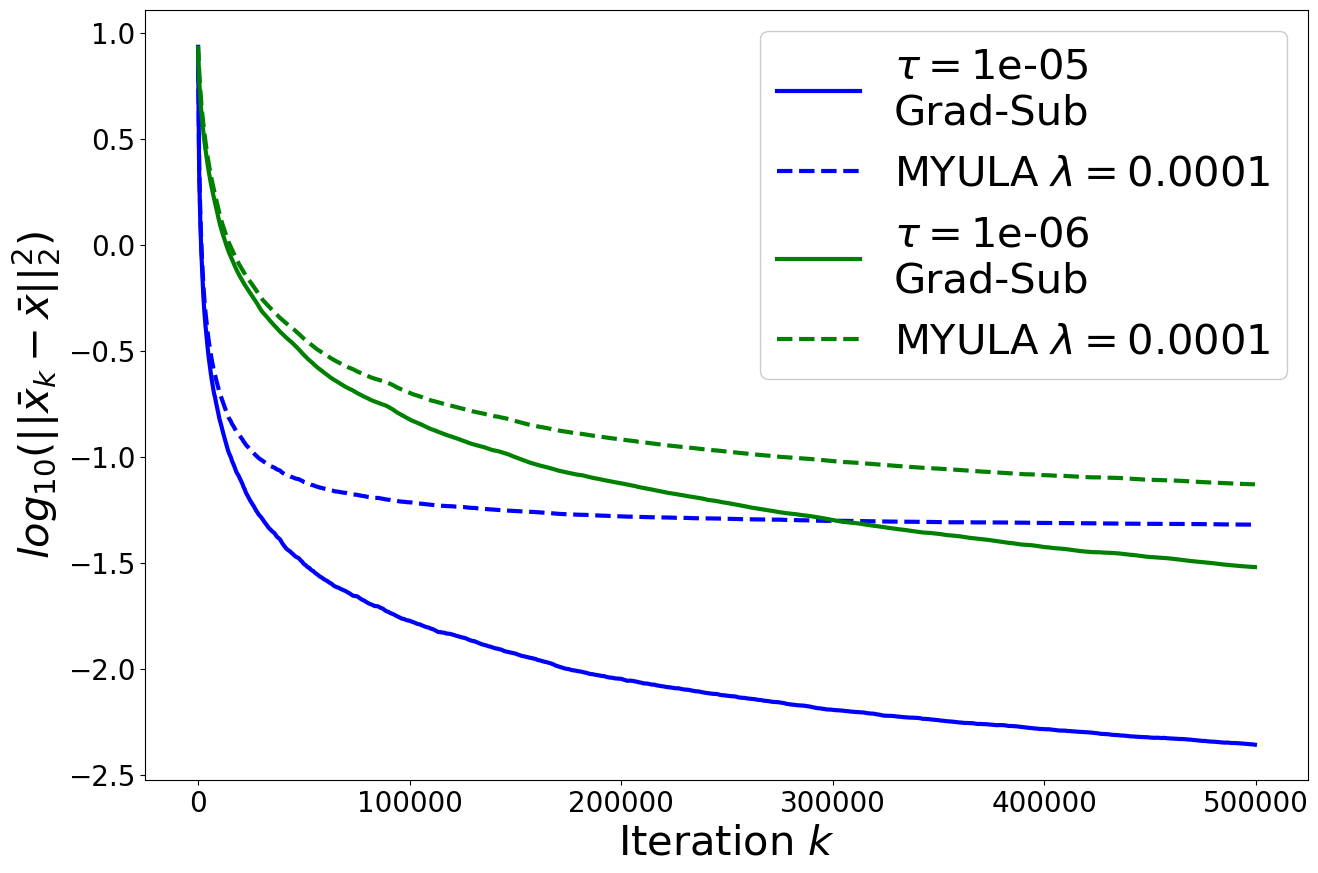

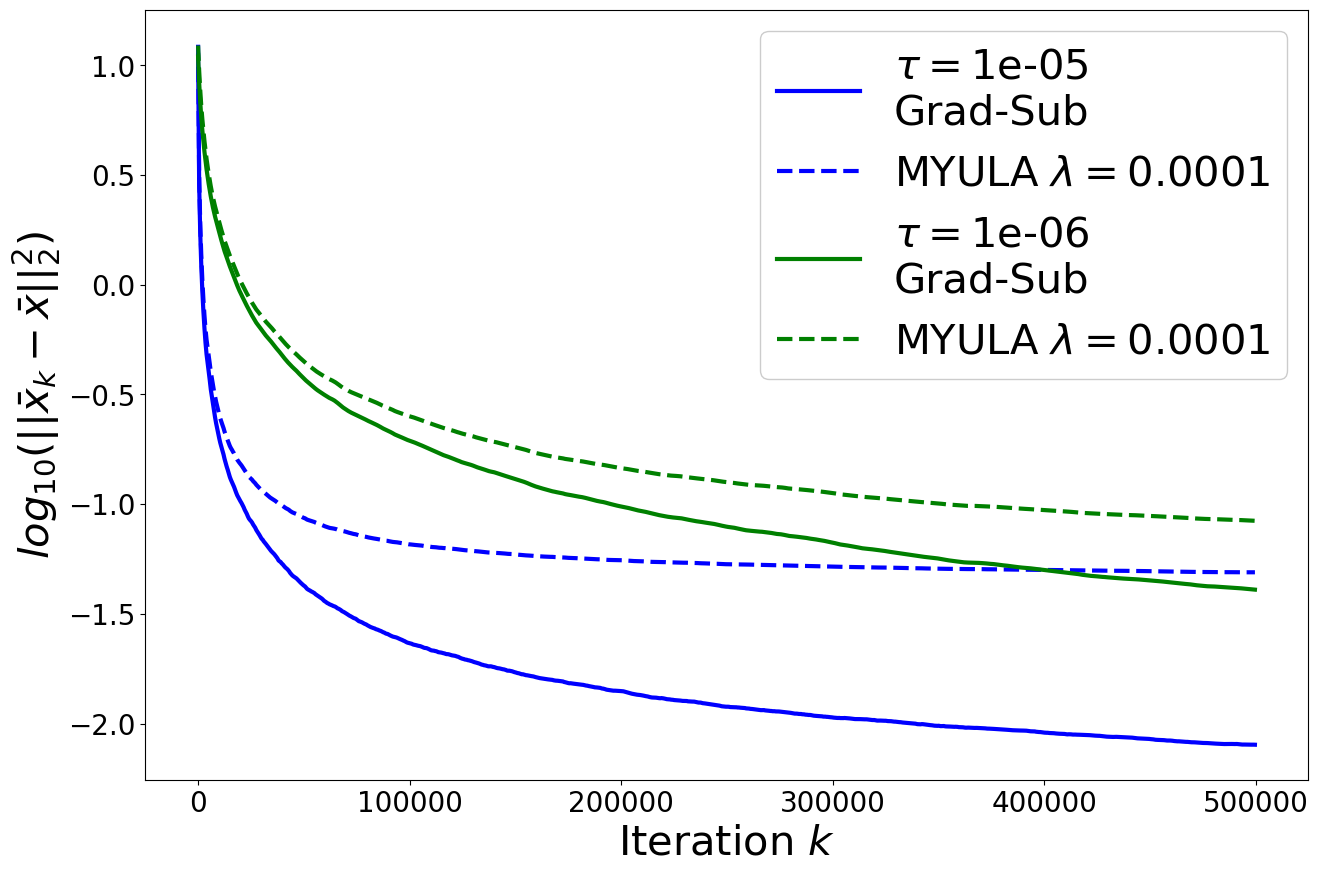

In [8]:
iterations = np.array(list(range(0,int(niter+1),500)))
c = ['b', 'g','r' , 'k']

for name in ['barbara','peppers_bw']:
    for reg_num,reg_par in enumerate(reg_par_list):
        plt.figure(figsize=(15,10))
        for tau_num,tau in enumerate(tau_list):
            plt.plot(iterations,np.log10(error_dict['subgrad'][name][reg_num,tau_num]),c[tau_num],linewidth=3,label=r'$\tau=$'+str(tau)+'\n'+'Grad-Sub')
            plt.plot(iterations,np.log10(error_dict['myula'][name][reg_num,tau_num]),c[tau_num]+'--',linewidth=3,label=r'MYULA $\lambda = $'+str(ld))
    
        matplotlib.rcParams.update({'font.size': 20})
        plt.xlabel('Iteration $k$',fontsize=30)
        plt.ylabel(r'$log_{10}(||\bar{x}_k - \bar{x}||^2_2)$',fontsize=30)
        plt.legend(loc='upper right',framealpha=1,fontsize=30)
        plt.savefig('results/images_paper/image_denoising/'+name+'_reg_par'+str(reg_par)+'err.png')
        plt.show()
        #plt.close('all')

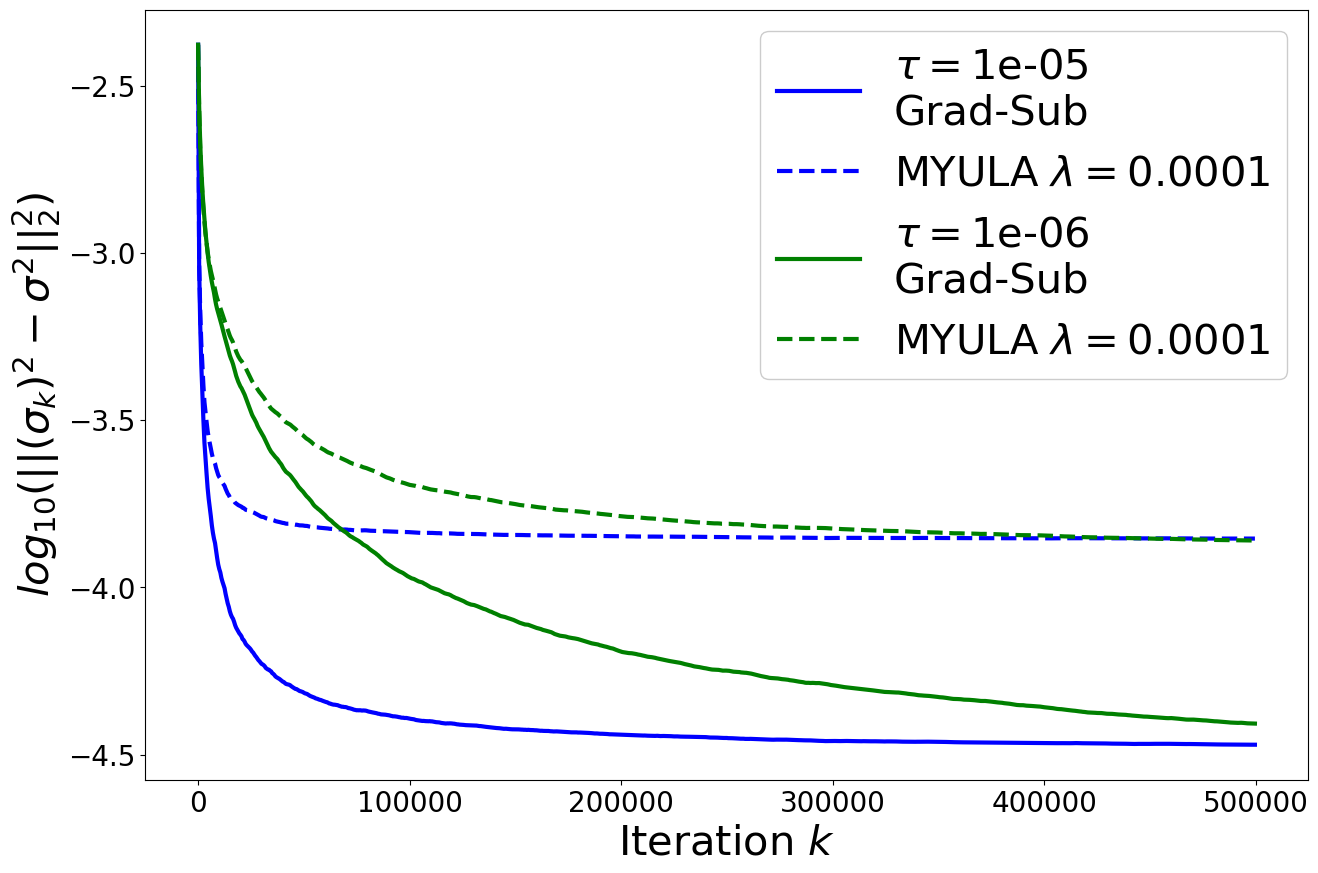

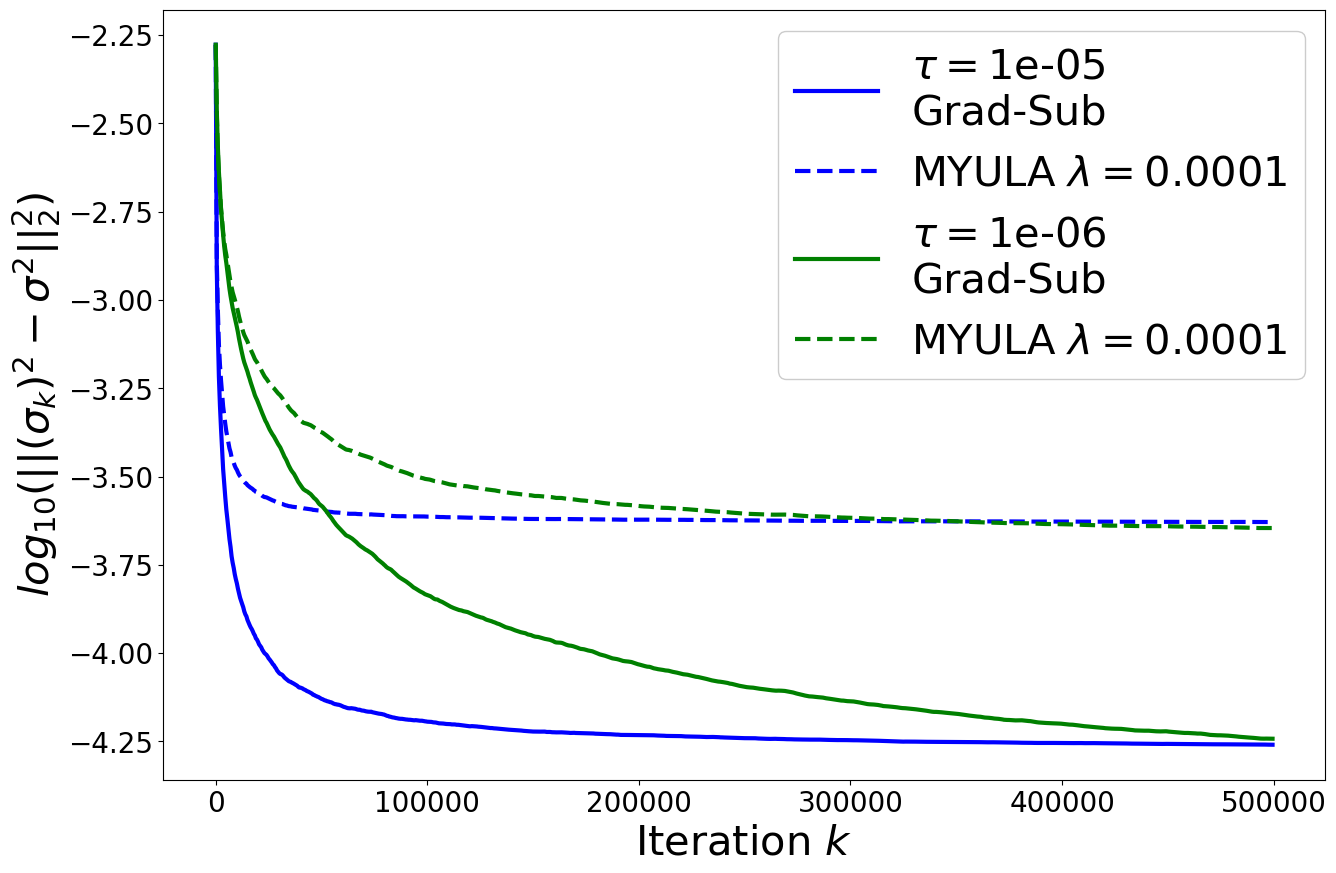

In [9]:
iterations = np.array(list(range(0,int(niter+1),500)))
c = ['b', 'g','r' , 'k']

for name in ['barbara','peppers_bw']:
    for reg_num,reg_par in enumerate(reg_par_list):
        plt.figure(figsize=(15,10))
        for tau_num,tau in enumerate(tau_list):
            plt.plot(iterations,np.log10(var_err_dict['subgrad'][name][reg_num,tau_num]),c[tau_num],linewidth=3,label=r'$\tau=$'+str(tau)+'\n'+'Grad-Sub')
            plt.plot(iterations,np.log10(var_err_dict['myula'][name][reg_num,tau_num]),c[tau_num]+'--',linewidth=3,label=r'MYULA $\lambda = $'+str(ld))
    
        matplotlib.rcParams.update({'font.size': 20})
        plt.xlabel('Iteration $k$',fontsize=30)
        plt.ylabel(r'$log_{10}(||(\sigma_k)^2 - \sigma^2||^2_2)$',fontsize=30)
        plt.legend(loc='upper right',framealpha=1,fontsize=30)
        plt.savefig('results/images_paper/image_denoising/'+name+'_reg_par'+str(reg_par)+'var_err.png')
        plt.show()
        #plt.close('all')

# For Deconvolution

In [20]:
c = ['b', 'g','r' , 'k']
error_dict = {}
var_err_dict = {}
tau_list=[1e-5,1e-6]
tau_list=[1e-6]
reg_par_list = [20]
niter = int(5e5-1000)
burnin = int(5e5)
step = 500
metro_iter = int(2e6-500)
ld = 1e-4
delta = 1e-3

images_folder = Path(f'results/images_paper/deconvolution/')
results_folder = Path(f'results/imaging_examples/deconvolution/')
results_folder_metro = Path(f'results/imaging_examples/deconvolution/subgrad/metro')

images_folder.mkdir(parents=True, exist_ok=True)
results_folder.mkdir(parents=True, exist_ok=True)
results_folder_BP.mkdir(parents=True, exist_ok=True)

for method in ['subgrad','myula']:
    error_dict_method = {}
    var_err_dict_method = {}
    (images_folder / method).mkdir(parents=True, exist_ok=True)
    for name in ['peppers_bw','barbara']:
        if name == 'barbara':
            vmax = 0.0031
            vmin = 0.0005
        else:
            vmax = 0.011
            vmin = 0.0001
        err = np.zeros([len(reg_par_list),len(tau_list),round(niter//step)+1])
        var_err = np.zeros([len(reg_par_list),len(tau_list),round(niter//step)+1])
        for reg_num,reg_par in enumerate(reg_par_list):

            u_metro = np.load(results_folder_metro /f'{name}/data_par_10000.0reg_par_{reg_par}delta_{delta}/tau_1e-06_iter_{metro_iter}_mmse.npy').squeeze()
            var_metro = np.load(results_folder_metro /f'{name}/data_par_10000.0reg_par_{reg_par}delta_{delta}/tau_1e-06_iter_{metro_iter}_variance.npy').squeeze()

            plt.imsave(images_folder / f'{name}_data_par_10000.0reg_par_{reg_par}delta_{delta}_tau_1e-06_iter_1999500_mmse.png',
                       u_metro,vmin=0,vmax=1,cmap='gray')
            plt.imsave(images_folder / f'{name}_data_par_10000.0reg_par_{reg_par}delta_{delta}_tau_1e-06_iter_1999500_variance.png',
                       var_metro,cmap='hot',vmin=vmin,vmax=vmax)

            for tau_num,tau in enumerate(tau_list):

                if method=='myula':
                    params_name = f'ld_{ld}_tau_{tau}'
                elif method=='subgrad':
                    params_name = f'tau_{tau}'

                u_langevin = np.load(results_folder / f'{method}/{name}/data_par_10000.0reg_par_{reg_par}delta_{delta}/{params_name}_iter_{int(burnin+niter)}_mmse.npy').squeeze()
                var_langevin = np.load(results_folder / f'{method}/{name}/data_par_10000.0reg_par_{reg_par}delta_{delta}/{params_name}_iter_{int(burnin+niter)}_variance.npy').squeeze()
                x0 = np.load(results_folder / f'{method}/{name}/data_par_10000.0reg_par_{reg_par}delta_{delta}/{params_name}_x0.npy').squeeze()
                plt.imsave(images_folder / f'{method}/{name}_x0.png',
                          x0.squeeze(),vmin=0,vmax=1,cmap='gray')

                plt.imsave(images_folder / f'{method}/{name}_data_par_10000.0reg_par_{reg_par}delta_{delta}_{params_name}_iter_{int(burnin+niter)}_mmse.png',
                          u_langevin.squeeze(),vmin=0,vmax=1,cmap='gray')
                plt.imsave(images_folder / f'{method}/{name}_data_par_10000.0reg_par_{reg_par}delta_{delta}_{params_name}_iter_{int(burnin+niter)}_variance.png',
                          var_langevin.squeeze(),cmap='hot',vmin=vmin,vmax=vmax)
                
                f = plt.figure(frameon=False)
                f = plt.imshow(var_langevin.squeeze(),cmap='hot',extent = (0,1,0,1),vmin=vmin,vmax=vmax)
                plt.colorbar(f)
                plt.tick_params(which = 'both', size = 0, labelsize = 0)
                plt.savefig(images_folder / f'{method}/{name}_data_par_10000.0reg_par_{reg_par}delta_{delta}_{params_name}_iter_{int(burnin+niter)}_variance_colorbar.png')
                plt.close('all')

                for r,i in enumerate(range(burnin,int(burnin+niter+1),step)):
                    
                    u_langevin = np.load(results_folder/ f'{method}/{name}/data_par_10000.0reg_par_{reg_par}delta_{delta}/{params_name}_iter_{i}_mmse.npy').squeeze()
                    var_langevin = np.load(results_folder/ f'{method}/{name}/data_par_10000.0reg_par_{reg_par}delta_{delta}/{params_name}_iter_{i}_variance.npy').squeeze()
                    err[reg_num,tau_num,r] = np.sum(np.square(u_langevin-u_metro))
                    var_err[reg_num,tau_num,r] = np.sum(np.square(var_langevin-var_metro))

        error_dict_method[name] = np.copy(err)
        var_err_dict_method[name] = np.copy(var_err)
    error_dict[method] = copy.deepcopy(error_dict_method)
    var_err_dict[method] = copy.deepcopy(var_err_dict_method)



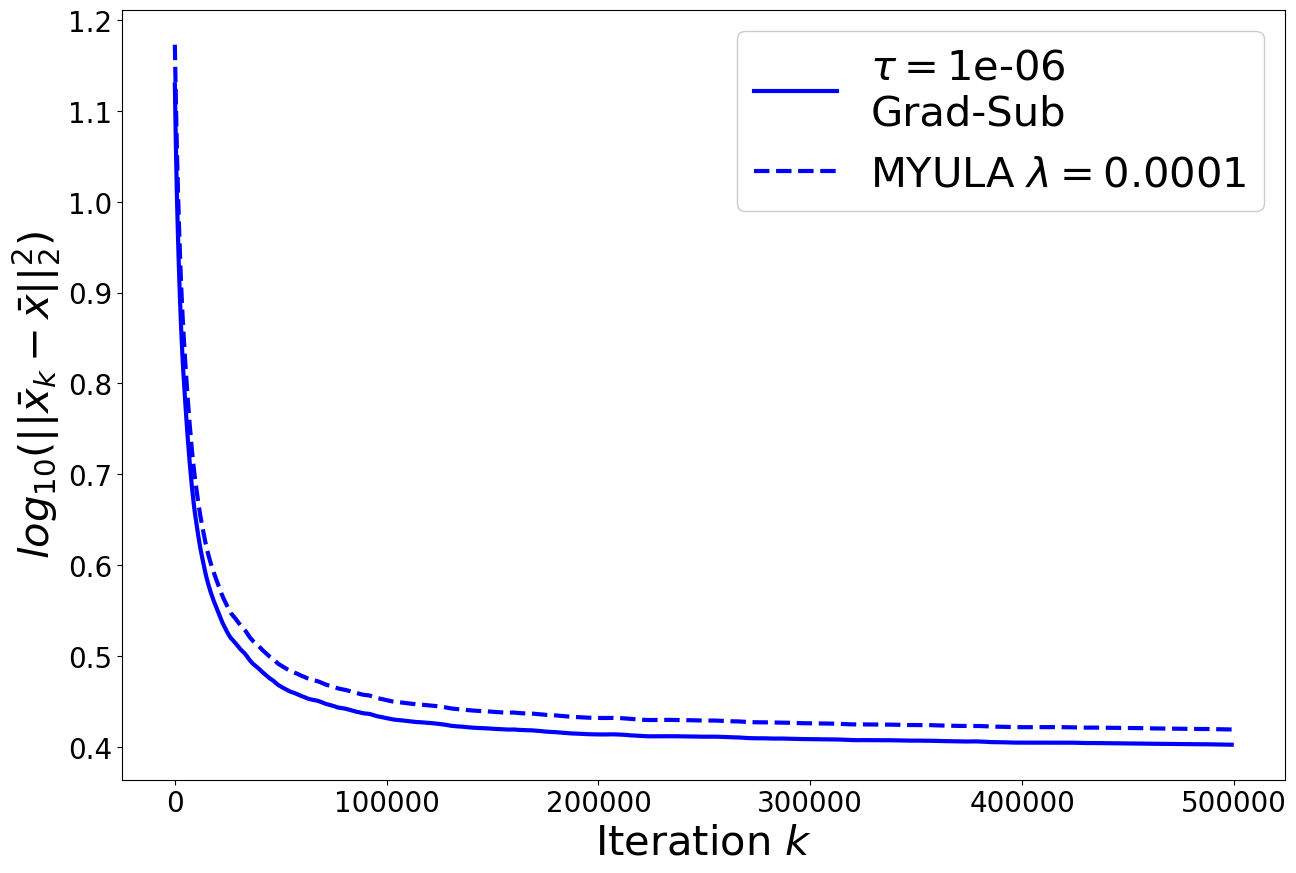

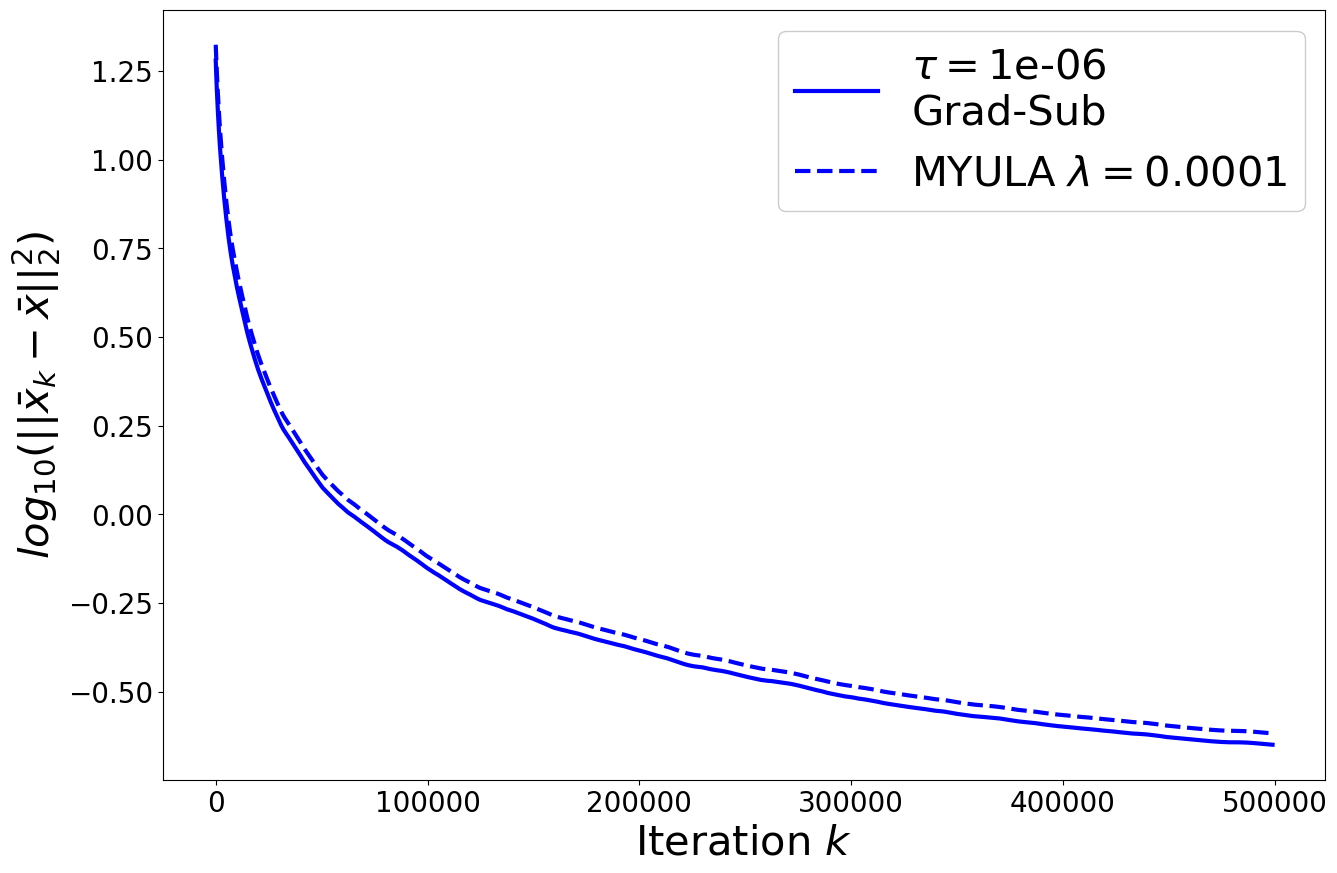

In [21]:
iterations = np.array(list(range(0,int(niter+1),step)))

for name in ['barbara','peppers_bw']:
    for reg_num,reg_par in enumerate(reg_par_list):
        plt.figure(figsize=(15,10))
        for tau_num,tau in enumerate(tau_list):
            plt.plot(iterations,np.log10(error_dict['subgrad'][name][reg_num,tau_num]),c[tau_num],linewidth=3,label=r'$\tau=$'+str(tau)+'\n'+'Grad-Sub')
            plt.plot(iterations,np.log10(error_dict['myula'][name][reg_num,tau_num]),c[tau_num]+'--',linewidth=3,label=r'MYULA $\lambda = $'+str(ld))
    
        matplotlib.rcParams.update({'font.size': 20})
        plt.xlabel('Iteration $k$',fontsize=30)
        plt.ylabel(r'$log_{10}(||\bar{x}_k - \bar{x}||^2_2)$',fontsize=30)
        plt.legend(loc='upper right',framealpha=1,fontsize=30)
        plt.savefig('results/images_paper/deconvolution/'+name+'_reg_par'+str(reg_par)+'err.png')
        plt.show()

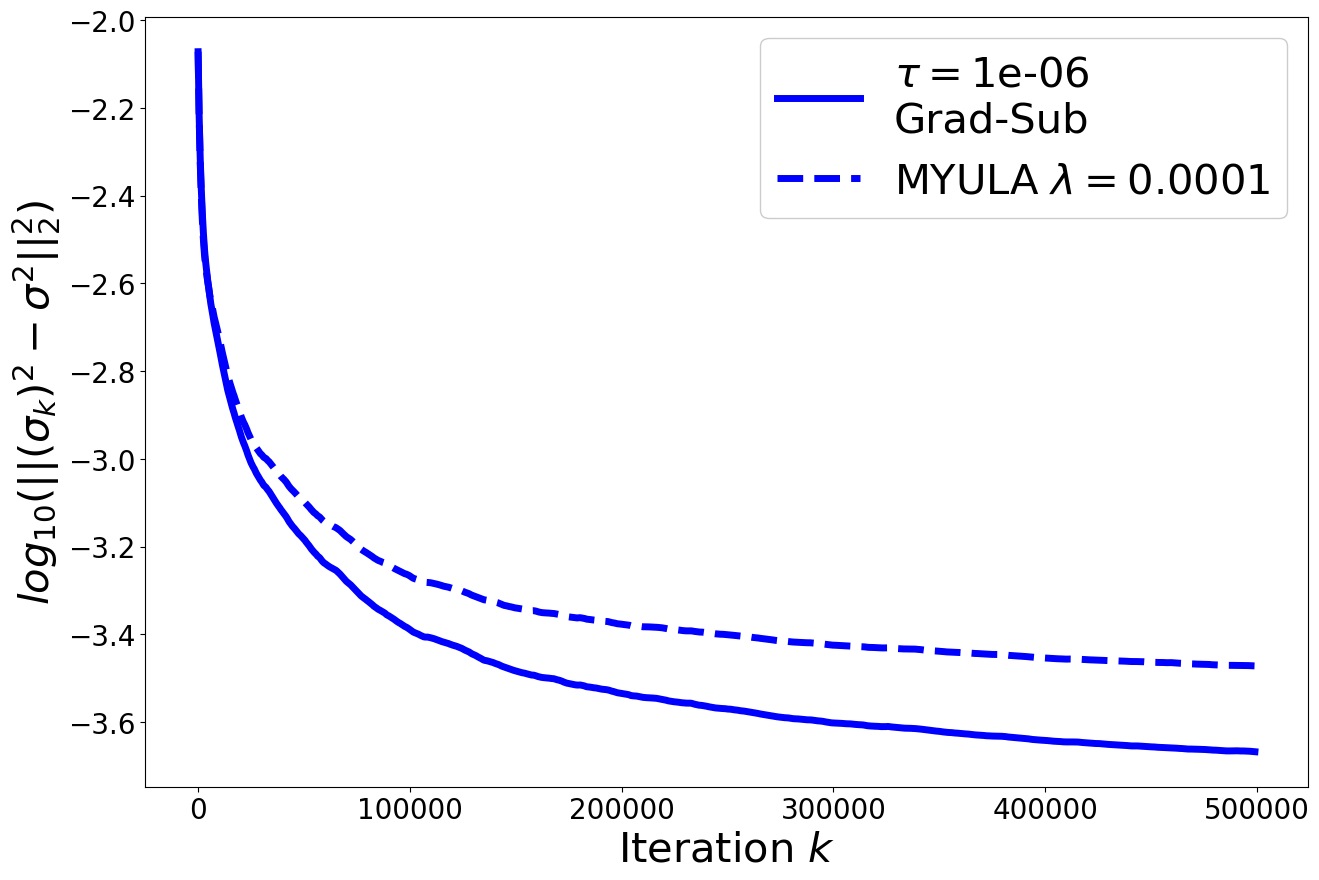

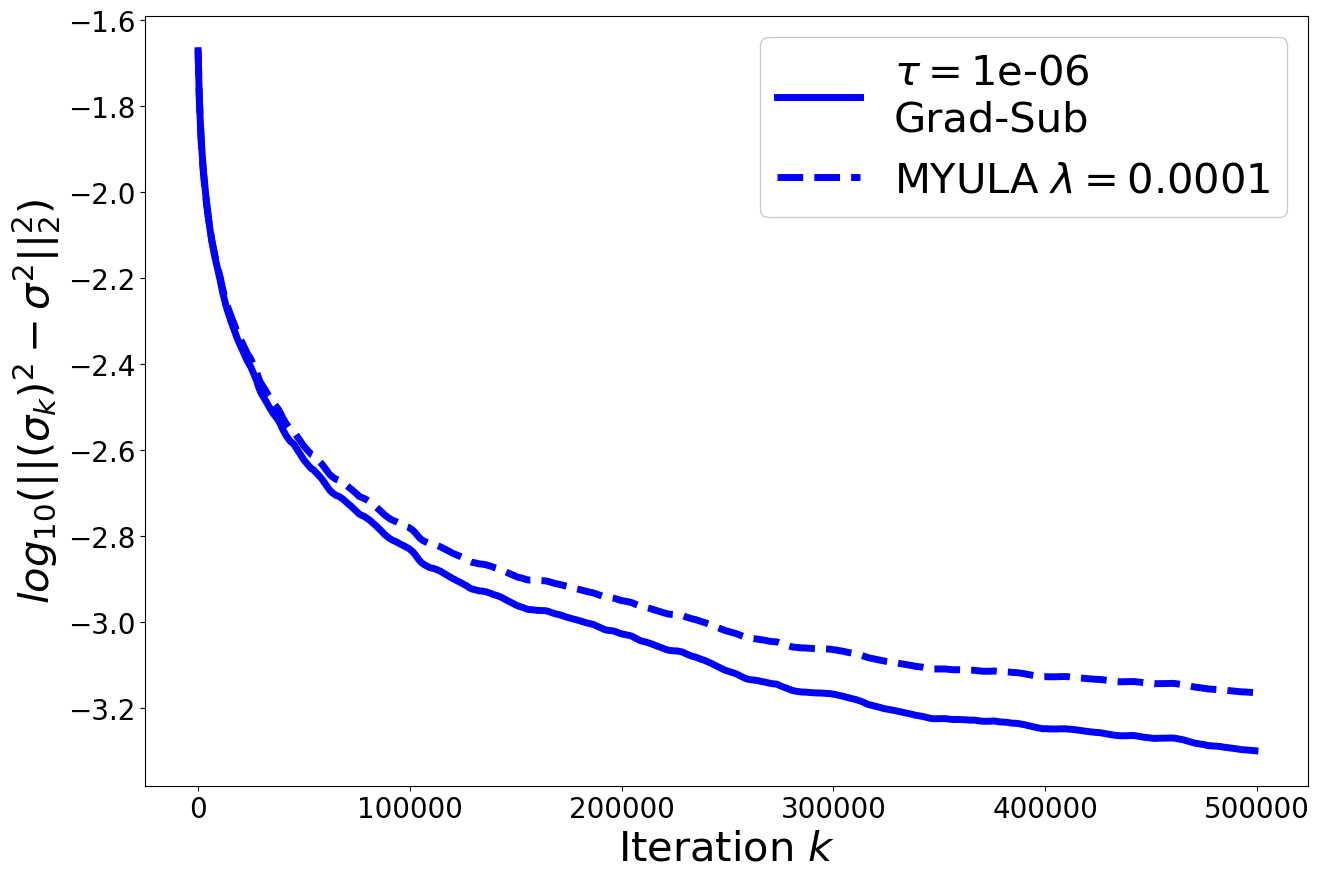

In [22]:
iterations = np.array(list(range(0,int(niter+1),step)))

for name in ['barbara','peppers_bw']:
    for reg_num,reg_par in enumerate(reg_par_list):
        plt.figure(figsize=(15,10))
        for tau_num,tau in enumerate(tau_list):
            plt.plot(iterations,np.log10(var_err_dict['subgrad'][name][reg_num,tau_num]),c[tau_num],linewidth=5,label=r'$\tau=$'+str(tau)+'\n'+'Grad-Sub')
            plt.plot(iterations,np.log10(var_err_dict['myula'][name][reg_num,tau_num]),c[tau_num]+'--',linewidth=5,label=r'MYULA $\lambda = $'+str(ld))
    
        matplotlib.rcParams.update({'font.size': 20})
        plt.xlabel('Iteration $k$',fontsize=30)
        plt.ylabel(r'$log_{10}(||(\sigma_k)^2 - \sigma^2||^2_2)$',fontsize=30)
        plt.legend(loc='upper right',framealpha=1,fontsize=30)
        plt.savefig('results/images_paper/deconvolution/'+name+'_reg_par'+str(reg_par)+'var_err.png')
        plt.show()

In [11]:
# MYULA times

im_name = 'peppers_bw' 
problem = 'deconvolution' # deconvolution denoising
method = 'subgrad' # myula subgrad
reg_par = {'denoising':30,'deconvolution':20}
data_par = {'denoising':399.99999999999994,'deconvolution':10000.0}

tau = 1e-6
folder = Path(f'results/imaging_examples/{problem}/') / method

folder_im = folder / im_name / f'data_par_{data_par[problem]}reg_par_{reg_par[problem]}'
times = np.load(f'{str(folder_im)}/tau_{tau}.npy')

np.mean(times)



1.4284683623313903

46.45494535040855